# RNN based on time series: Predict Action and next steps

We aim to predict the next steps and actions based on time series

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pprint as pprint

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

### Get the data
First Import it using pandas

In [4]:

raw_dataset = pd.read_csv("./test.csv")

dataset = raw_dataset.copy()


We need all the path to have the same steps. Therefore we will trunk the path to the same lenght and omit those with reduced lenght

First we check with is the most common lenght

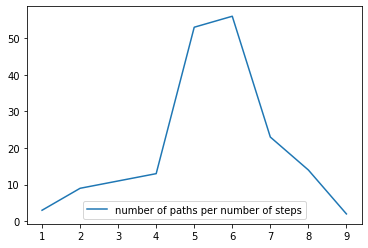

In [5]:
len_stat = dataset.groupby(["id_camino"]).size().reset_index(name='counts')
plt.plot(len_stat.groupby(["counts"]).size(), label ="number of paths per number of steps")
plt.legend()

We will cut at 4 steps (n=5) and remove the path with less than 4 steps

In [6]:
long_paths = len_stat[len_stat.counts>4]
red_dataset = dataset.loc[dataset["id_camino"].isin(long_paths["id_camino"])]
reg_dataset= red_dataset[red_dataset.id_in_seq<5] 
reg_dataset.head()

,id_camino,id_in_seq,current_state,goal_state,out_action,timesteps
20,8,0,"[0, 0, 1, 0, 0, 0]","[3355.2520452554118, -366.8261847192736, 1.151...",2,315.345581
21,8,1,"[557.2873618367145, -88.35404417578944, 1.9044...","[3355.2520452554118, -366.8261847192736, 1.151...",2,315.345581
22,8,2,"[1114.996313868046, -148.75498736770038, 1.794...","[3355.2520452554118, -366.8261847192736, 1.151...",2,315.345581
23,8,3,"[1676.8499244084107, -212.92073093890662, 1.78...","[3355.2520452554118, -366.8261847192736, 1.151...",2,315.345581
24,8,4,"[2237.5875630469245, -276.99235127691014, 1.79...","[3355.2520452554118, -366.8261847192736, 1.151...",3,315.345581


Finaly, the new goal state is the last state of each path
goal state = Path[4] 

In [7]:
for id in reg_dataset["id_camino"]:
     dummy = "a"
     dummy = reg_dataset.loc[(reg_dataset["id_camino"] == id) & (reg_dataset["id_in_seq"] == 4)].current_state
     for index in reg_dataset[reg_dataset["id_camino"] == id]:
         reg_dataset["goal_state"][index] = dummy

reg_dataset.head()

,id_camino,id_in_seq,current_state,goal_state,out_action,timesteps
20,8,0,"[0, 0, 1, 0, 0, 0]","[3355.2520452554118, -366.8261847192736, 1.151...",2,315.345581
21,8,1,"[557.2873618367145, -88.35404417578944, 1.9044...","[3355.2520452554118, -366.8261847192736, 1.151...",2,315.345581
22,8,2,"[1114.996313868046, -148.75498736770038, 1.794...","[3355.2520452554118, -366.8261847192736, 1.151...",2,315.345581
23,8,3,"[1676.8499244084107, -212.92073093890662, 1.78...","[3355.2520452554118, -366.8261847192736, 1.151...",2,315.345581
24,8,4,"[2237.5875630469245, -276.99235127691014, 1.79...","[3355.2520452554118, -366.8261847192736, 1.151...",3,315.345581


In [8]:
reg_dataset["goal_state"]

20               [3355.2520452554118, -366.8261847192736, 1.151...
21               [3355.2520452554118, -366.8261847192736, 1.151...
22               [3355.2520452554118, -366.8261847192736, 1.151...
23               [3355.2520452554118, -366.8261847192736, 1.151...
24               [3355.2520452554118, -366.8261847192736, 1.151...
                                       ...                        
id_in_seq        996    [2145.6242327499517, -258.8787869368321...
current_state    996    [2145.6242327499517, -258.8787869368321...
goal_state       996    [2145.6242327499517, -258.8787869368321...
out_action       996    [2145.6242327499517, -258.8787869368321...
timesteps        996    [2145.6242327499517, -258.8787869368321...
Name: goal_state, Length: 746, dtype: object

In [9]:

dataset = reg_dataset

for index, row in dataset.iterrows():
    CS_array =np.array(eval(row["current_state"]))
    dataset["current_state"][index] = CS_array
    GS_array =np.array(eval(row["goal_state"]))
    dataset["goal_state"][index] = GS_array
    dataset["out_action"][index] = int(dataset["out_action"][index])

dataset["Difference"] =   dataset["goal_state"]-dataset["current_state"]

dataset[["C0",'C1',"C2","C3",'C4',"C5"]] = pd.DataFrame(dataset.current_state.values.tolist(), index= dataset.index)
dataset[["D0",'D1',"D2","D3",'D4',"D5"]] = pd.DataFrame(dataset.Difference.values.tolist(), index= dataset.index)


In [10]:
dataset[0:10]

,id_camino,id_in_seq,current_state,goal_state,out_action,timesteps,Difference,C0,C1,C2,C3,C4,C5,D0,D1,D2,D3,D4,D5
20,8,0,"[0, 0, 1, 0, 0, 0]","[3355.2520452554118, -366.8261847192736, 1.151...",2,315.345581,"[3355.2520452554118, -366.8261847192736, 0.151...",0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3355.252045,-366.826185,0.151482,0.183113,0.052711,-0.001145
21,8,1,"[557.2873618367145, -88.35404417578944, 1.9044...","[3355.2520452554118, -366.8261847192736, 1.151...",2,315.345581,"[2797.9646834186974, -278.47214054348416, -0.7...",557.287362,-88.354044,1.904406,0.117667,-0.007043,0.001597,2797.964683,-278.472141,-0.752924,0.065446,0.059754,-0.002742
22,8,2,"[1114.996313868046, -148.75498736770038, 1.794...","[3355.2520452554118, -366.8261847192736, 1.151...",2,315.345581,"[2240.255731387366, -218.07119735157323, -0.64...",1114.996314,-148.754987,1.794546,0.119579,-0.059903,0.000014,2240.255731,-218.071197,-0.643064,0.063534,0.112614,-0.001159
23,8,3,"[1676.8499244084107, -212.92073093890662, 1.78...","[3355.2520452554118, -366.8261847192736, 1.151...",2,315.345581,"[1678.402120847001, -153.905453780367, -0.6384...",1676.849924,-212.920731,1.789949,0.119717,-0.045089,-0.000059,1678.402121,-153.905454,-0.638468,0.063397,0.097800,-0.001086
24,8,4,"[2237.5875630469245, -276.99235127691014, 1.79...","[3355.2520452554118, -366.8261847192736, 1.151...",3,315.345581,"[1117.6644822084872, -89.83383344236347, -0.64...",2237.587563,-276.992351,1.794838,0.119611,-0.047056,0.000015,1117.664482,-89.833833,-0.643357,0.063503,0.099767,-0.001159
27,9,0,"[0, 0, 1, 0, 0, 0]","[2907.0542848353966, -263.57882736991, 1.16306...",3,315.345581,"[2907.0542848353966, -263.57882736991, 0.16306...",0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2907.054285,-263.578827,0.163066,0.182490,0.065083,-0.000678
28,9,1,"[467.51084210168455, -52.85735936140974, 1.396...","[2907.0542848353966, -263.57882736991, 1.16306...",4,315.345581,"[2439.5434427337123, -210.72146800850027, -0.2...",467.510842,-52.857359,1.396266,0.147218,0.014904,-0.002213,2439.543443,-210.721468,-0.233200,0.035272,0.050179,0.001535
29,9,2,"[881.3909271559311, -87.82787195861813, 1.3092...","[2907.0542848353966, -263.57882736991, 1.16306...",4,315.345581,"[2025.6633576794657, -175.7509554112919, -0.14...",881.390927,-87.827872,1.309273,0.164303,0.046378,0.000011,2025.663358,-175.750955,-0.146207,0.018187,0.018705,-0.000689
30,9,3,"[1293.8754807566058, -124.08675633965926, 1.30...","[2907.0542848353966, -263.57882736991, 1.16306...",4,315.345581,"[1613.1788040787908, -139.49207103025077, -0.1...",1293.875481,-124.086756,1.306958,0.164448,0.036881,-0.000074,1613.178804,-139.492071,-0.143892,0.018042,0.028202,-0.000604
31,9,4,"[1706.6741019079343, -160.4873748066237, 1.309...","[2907.0542848353966, -263.57882736991, 1.16306...",4,315.345581,"[1200.3801829274623, -103.09145256328631, -0.1...",1706.674102,-160.487375,1.309686,0.164356,0.036761,0.000006,1200.380183,-103.091453,-0.146620,0.018134,0.028322,-0.000683


### Clean the data


check if the data contains unknown values.

In [10]:
dataset.isna().sum()

id_camino        0
id_in_seq        0
current_state    0
goal_state       0
out_action       0
timesteps        0
Difference       0
C0               0
C1               0
C2               0
C3               0
C4               0
C5               0
D0               0
D1               0
D2               0
D3               0
D4               0
D5               0
dtype: int64

To keep this initial tutorial simple drop those rows.

In [11]:
dataset = dataset.dropna()

### Split the data into train and test

Now split the dataset into a training set and a test set.

We take the first TRAIN_SPLIT values as train data

We will use the test set in the final evaluation of our model.

In [11]:
dataset  = dataset[["id_in_seq","D0",'D1',"D2","D3",'D4',"D5","out_action"]]


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [19]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index, step):
    indices = range(i-history_size, i)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [13]:
dataset2 = dataset.values

In [36]:
TRAIN_SPLIT = 20
past_history = 4
future_target = 0
STEP = 5

x_train_single, y_train_single = multivariate_data(dataset2, dataset2[:, 7], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset2, dataset2[:, 7],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [38]:
print(y_train_single)
print(y_val_single[:])



[3. 4. 5. 3.]
[4. 3. 3. 5. 2. 2. 3. 5. 4. 4. 5. 3. 4. 5. 4. 4. 2. 5. 5. 5. 4. 2. 2. 4.
 5. 4. 2. 3. 5. 2. 5. 4. 3. 2. 4. 5. 1. 5. 1. 1. 5. 5. 1. 4. 4. 5. 4. 3.
 4. 5. 2. 5. 5. 4. 3. 3. 1. 3. 2. 2. 3. 5. 4. 3. 3. 5. 3. 5. 2. 3. 3. 3.
 4. 1. 4. 1. 3. 3. 3. 1. 1. 3. 2. 2. 4. 3. 1. 3. 2. 4. 5. 3. 1. 4. 5. 2.
 4. 4. 4. 4. 1. 4. 4. 2. 3. 2. 5. 4. 3. 4. 1. 3. 1. 3. 1. 3. 3. 1. 3. 4.
 4. 2. 1. 2. 3. 5. 2. 3. 1. 3. 4. 4. 1. 3. 3. 3. 3. 5. 5. 4. 5. 4. 1. 2.]


It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [10]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
# normed_train_data = norm(train_dataset)
# normed_test_data = norm(test_dataset)


This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

In [42]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (4, 8)


## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [40]:
BATCH_SIZE = 5
BUFFER_SIZE = 10000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [41]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [43]:
single_step_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                5248      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________



Now try out the model. Take a batch of BATCH_SIZE examples from the training data and call `model.predict` on it.

In [44]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(5, 1)


It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [45]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 8s 40ms/step - loss: 2.6621 - val_loss: 1.3304
Epoch 2/10
200/200 [==============================] - 2s 10ms/step - loss: 0.8618 - val_loss: 0.9759
Epoch 3/10
200/200 [==============================] - 2s 9ms/step - loss: 0.7372 - val_loss: 0.9852
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 0.7081 - val_loss: 0.9906
Epoch 5/10
200/200 [==============================] - 2s 10ms/step - loss: 0.6642 - val_loss: 1.0518
Epoch 6/10
200/200 [==============================] - 2s 10ms/step - loss: 0.6023 - val_loss: 1.0057
Epoch 7/10
200/200 [==============================] - 2s 10ms/step - loss: 0.5278 - val_loss: 0.9892
Epoch 8/10
200/200 [==============================] - 1s 7ms/step - loss: 0.4889 - val_loss: 0.9563
Epoch 9/10
200/200 [==============================] - 2s 8ms/step - loss: 0.4611 - val_loss: 0.9872
Epoch 10/10
200/200 [==============================]

Visualize the model's training progress.

In [56]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

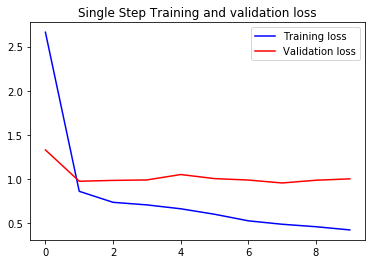

In [57]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

## Predict a single step future

In [61]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [64]:
def create_time_steps(length):
  return list(range(-length, 0))

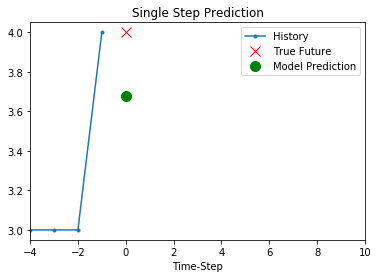

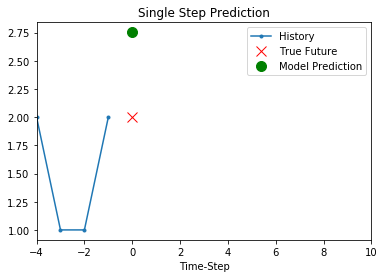

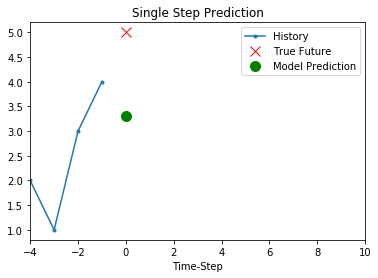

In [67]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 7].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 0,
                   'Single Step Prediction')
  plot.show()